## Introduction
After having trained a model on the AWS GPU instance, it is time to see how it is performing. I will begin with simple visualizing of the spec files and target/predicted bboxes, but this can only take us so far in understanding model performance. I begin by looking at the Intersection over Union (IoU) metric for all possible combinations of targets/predictions, but eventually implemented my own Mean Average Precision (mAP) method as it is supposed to be the best way of evaluating object detection performance. Unfortunately I couldn't get the full precision-recall curve (recall bottomed out at ~.7), so instead I looked at a more accurate IoU aggregate after matching a prediction box to its nearest target, and only keeping these IoU values for calculating the mean. 

In [387]:
# Standard imports
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import sys
import yaml
import json
from typing import List, Union

# Deep learning imports.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.utils import draw_bounding_boxes, make_grid

import torchvision
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou, nms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics

from modeling import CRES_Dataset, CRES_DM, CRES_LM
root_dir = sys.path[0]+'/config/fasterRCNN'

#### Loading saved model

In [388]:
PATH = 'tb_logs/cres/version_{}/checkpoints/epoch={:02d}.ckpt'.format(56, 96)
cres_lm = CRES_LM.load_from_checkpoint(PATH)

In [389]:
# Define training object, max_pool=16, file_max=1000, batch_size=1 correspond to 
# the conditions for the model 56 inside of tb_logs
cres_dm = CRES_DM(root_dir,
                  max_pool=16,
                  file_max=1000,
                  batch_size=1,
                  num_workers=4
                  )

#### Generate some predictions

In [390]:
test_dataiter = iter(cres_dm.test_dataloader())
imgs, targets = test_dataiter.next()
preds = cres_lm(imgs)
preds

[{'boxes': tensor([[146.5394, 160.3418, 319.6300, 167.0255],
          [171.9239, 118.2621, 319.6597, 124.9091],
          [204.2013, 144.0251, 319.3449, 146.0231],
          [ 55.0153, 249.9287, 248.4135, 252.0918],
          [297.8691, 189.0088, 319.7892, 190.0078]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1]),
  'scores': tensor([1.0000, 1.0000, 1.0000, 0.9999, 0.9995], grad_fn=<IndexBackward0>)}]

## Visualize

In [391]:
def apply_score_cut(preds, score_threshold=0.5):
    """
    Takes a list of prediction dictionaries (one for each image) and cuts
    out all instances whose score is below the score threshold.

    Args:
        preds (List[Dict[torch.Tensor]]): predictions as output by the
            torchvision implimentation of MaskRCNN or FasterRCNN. The 
            scores are in the range (0,1) and signify the certainty of 
            the model for that instance.
            See link below for details on the target/prediction formatting.
            https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/mask_rcnn.html
        score_threshold (float): the threshold to apply to the identified
            objects. If an instance is below the score_threshold it will
            be removed from the score_thresholded_preds dictionary.

    Returns:
        score_thresholded_preds (List[Dict[torch.Tensor]]): predictions
            that exceed score_threshold.
    """
    score_thresholded_preds = [
        {key: value[pred["scores"] > score_threshold] for key, value in pred.items()}
        for pred in preds
    ]

    return score_thresholded_preds

def show(imgs, figsize=(10.0, 10.0)):
    """Displays a single image or list of images. Taken more or less from
    the pytorch docs:
    https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#visualizing-a-grid-of-images

    Args:
        imgs (Union[List[torch.Tensor], torch.Tensor]): A list of images
            of shape (3, H, W) or a single image of shape (3, H, W).
        figsize (Tuple[float, float]): size of figure to display.

    Returns:
        None
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), figsize=figsize, squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), origin='lower')
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.title('Spectrogram with target and predicted bboxes')
    plt.show()

    return None

def display_boxes(imgs, target_pred_dict, class_map, width = 1, fill=False):
    """
    Takes a list of images and a list of target or prediction dictionaries
    of the same len and overlays bounding boxes onto the images.
    Returns:
        result_imgs (List[torch.ByteTensor[3, H, W]]): list of images with
            overlaid bounding boxes.
    """
    if fill:
        color = (255,0,0)
    else:
        color = (0,255,0)
    num_imgs = len(imgs)
    result_imgs = [
        draw_bounding_boxes(
            imgs[i].type(torch.uint8),
            target_pred_dict[i]["boxes"].int(),
            fill=fill,
            colors=[
                color
                for j in target_pred_dict[i]["labels"]
            ],
            width=width,
        )
        for i in range(num_imgs)
    ]

    return result_imgs

In [397]:
%matplotlib widget
@interact
def vizualize_targets_predictions(
                                target_box = widgets.Checkbox(value=False,description='target boxes'),
                                pred_box = widgets.Checkbox(value=False,description='prediction boxes'),
                                num_imgs= widgets.IntSlider(value=len(preds),min=0,max=len(preds),step=1, description = "num_imgs"),
                                score_thresh = widgets.FloatSlider(value=.5,min=0,max=1,step=.0001, description = "score_thresh"),
                                width =  widgets.IntSlider(value=1,min=1,max=10,step=1), 
                                display_size = widgets.IntSlider(value=10,min=2,max=50,step=1)
                                ): 
    preds_cut = apply_score_cut(preds, score_threshold=score_thresh)
    result_image = [imgs[i] for i in range(num_imgs)]

    if target_box: 
        result_image = display_boxes(result_image, targets, cres_dm.class_map, fill = True)

    if pred_box: 
        result_image = display_boxes(result_image, preds_cut, cres_dm.class_map)

    grid = make_grid(result_image)
    show(grid, figsize = (display_size, display_size))

interactive(children=(Checkbox(value=False, description='target boxes'), Checkbox(value=False, description='pr…

#### Rerun this cell in order to generate new image above.

In [396]:
imgs, targets = test_dataiter.next()
preds = cres_lm(imgs)

## Model Performance with IoU
IoU is a valuable metric for object detection. It is the ratio of the intersection area of the target and prediction boundary box to the union area of the boxes, so a value of 1 is perfect overlap and 0 is no overlap. The tricky part here is that the predictions are ordered by their score in the model, not by the order in which the targets were originally given. For now, I am aiming to get a lower bound on the model performance. This will be done by taking the IoU of all pairs of boxes in an image (between targets and predictions - the default behavior of `box_iou`) and keeping scores greater than 0. The average of this will include the IoU of boxes that just happen to overlap to some degree, hence it being a lower bound. However, it will allow for a better understanding of model performance.

#### Defining function to explore relationship of IoU threshold on application of Non Maximum Suppression to the predictions. Want to see if there is an ideal value which will give same number of predictions as targets

In [66]:
def get_ious(iou_threshold):
    '''
    Function for getting all of the IoU values for a predicted bbox in a given image.
    Also returns the number of targets and predictions in an image after applying NMS.
    '''
    ious = []
    pred_len = []
    targ_len = []
    test_dataiter = iter(cres_dm.test_dataloader())
    iterating = True
    i=0
    while iterating:
        try:
            # Update user that function is running
            if not i%25:
                print(f'On image {i}')
            # get image and target from test dataloader
            imgs, targets = test_dataiter.next()
            
            # generate prediction from model
            preds = cres_lm(imgs)
            # only take preds with score > .5
            preds = apply_score_cut(preds)
            
            # Apply NMS with given threshold
            keep = nms(preds[0]['boxes'], preds[0]['scores'], iou_threshold=iou_threshold)
            
            # Store the IoU for each prediction box that passes NMS
            ious += box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])\
            [box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])>0].tolist()
            
            # Also store if the number of predictions for the image match the number of targets
            # pred_targ_len.append(len(preds[0]['boxes'][keep]) == len(targets[0]['boxes']))
            pred_len.append(len(preds[0]['boxes']))
            targ_len.append(len(targets[0]['boxes']))
            
            # Increment sanity counter since this takes a while to run
            i+=1
        # eventually the iteration fails, so capture that here 
        except:
            # Just to guarantee that we exit the loop...
            iterating = False
            # Return IoU values and info on number of preds/targets
            return ious, pred_len, targ_len
        
def plot_ious(ious, thresholds):
    '''
    Function for plotting the output of the IoU function above
    '''
    for i, it in enumerate(thresholds):
        iou_temp = torch.detach(torch.tensor(ious[i][0])).numpy()
        plt.figure(figsize=(10,10))
        plt.scatter(list(range(len(iou_temp))), iou_temp, marker='.')
        plt.hlines(y=iou_temp.mean(),xmin=0, xmax=len(iou_temp), color='red', label=f'mean={iou_temp.mean().round(3):.3f}')
        plt.ylabel('IoU')
        plt.title(f'IoU for each prediction, NMS threshold = {it},\
     ratio of number targets to predictions={sum(ious[i][2])/sum(ious[i][1]) :.3f}')
        plt.legend()
        plt.show()
    return None

In [80]:
iou_thresholds = [.1, .3, .5]
iou_info = [get_ious(it) for it in iou_thresholds]

On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100


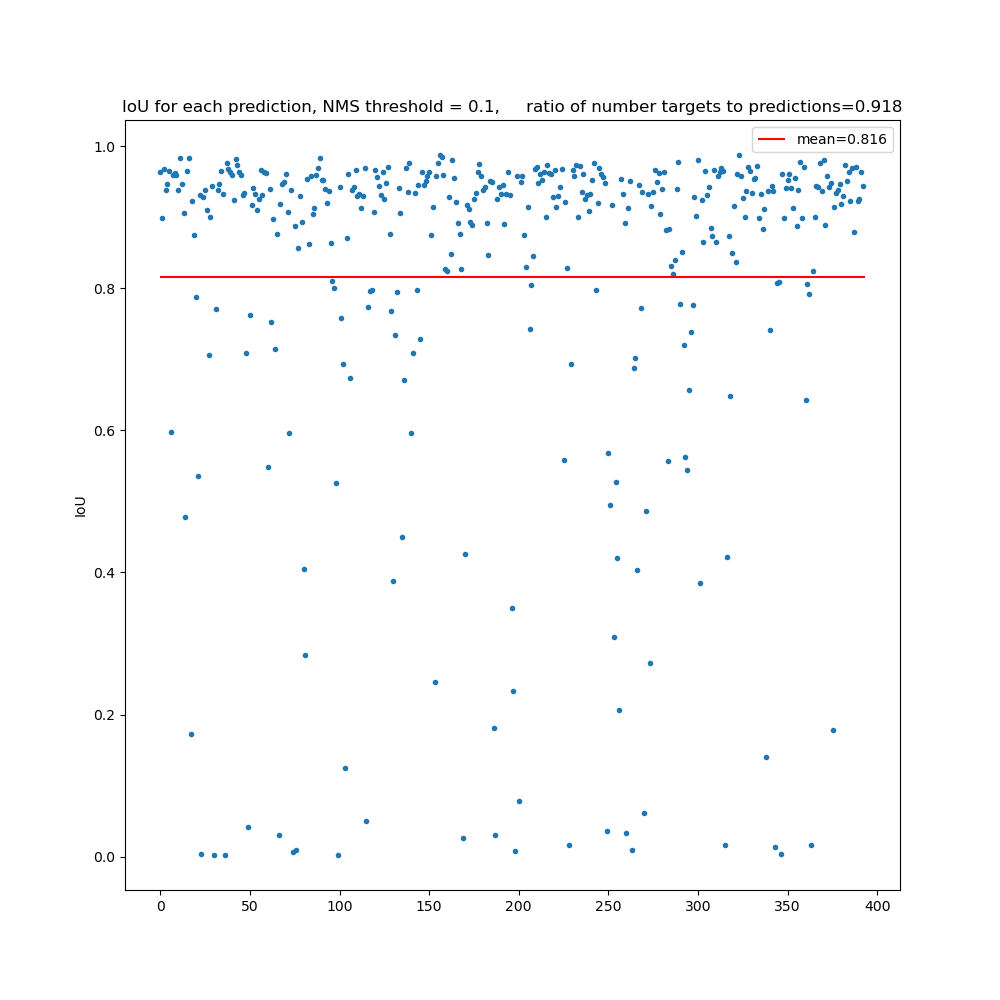

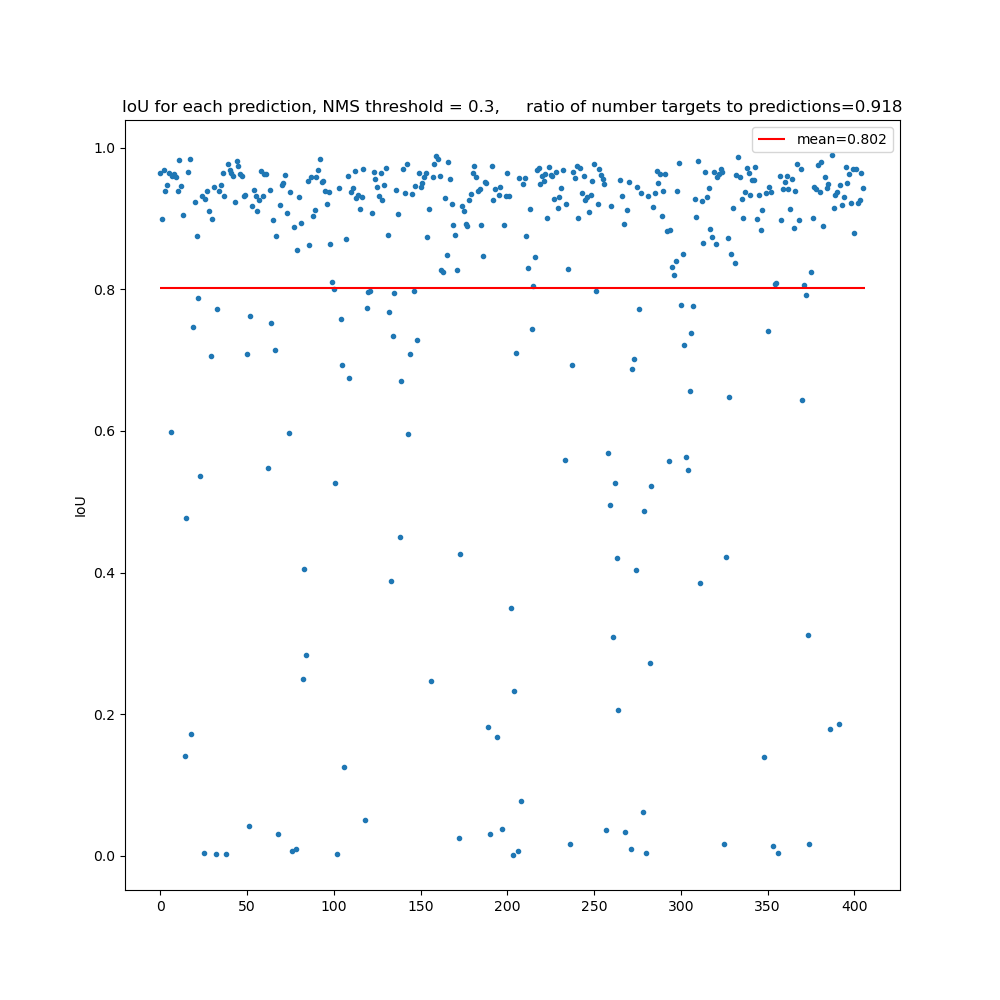

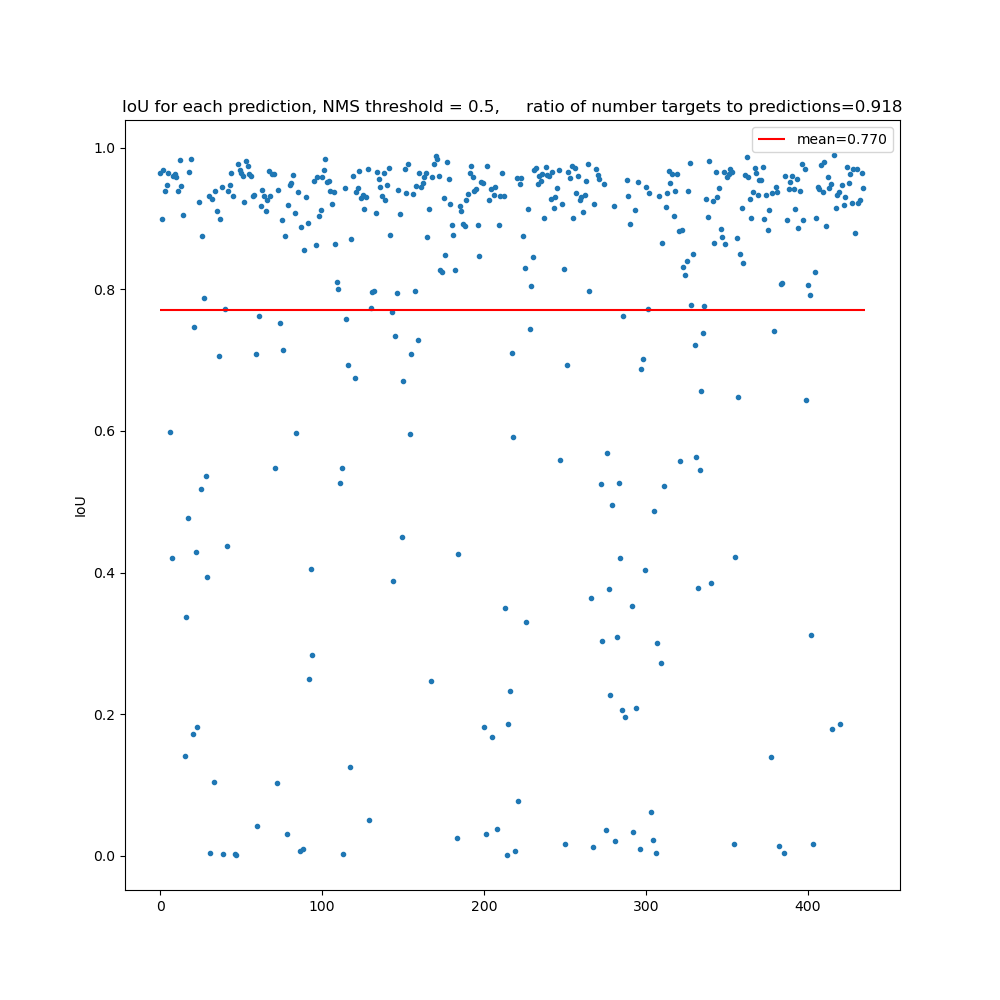

In [81]:
%matplotlib widget
plot_ious(iou_info, iou_thresholds)

#### Honestly surprised by this behavior. I was worried about cutting out too many events that do have overlapping boundary boxes, but increasing the threshold beyond .1 only led to worse performance both in terms of average IoU and number of images with correct number of predictions. Going to try exploring a threshold closer to .1.

In [ ]:
iou_thresholds_2 = [.01, .05, .2]
iou_info_2 = [get_ious(it) for it in iou_thresholds_2]

In [ ]:
%matplotlib widget
plot_ious(iou_info_2, iou_thresholds_2)

#### I guess smaller is better, going to continue making the threshold smaller until I see diminishing returns.

In [67]:
iou_thresholds_3 = [.005, .0075, .01]
iou_info_3 = [get_ious(it) for it in iou_thresholds_3]

On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100


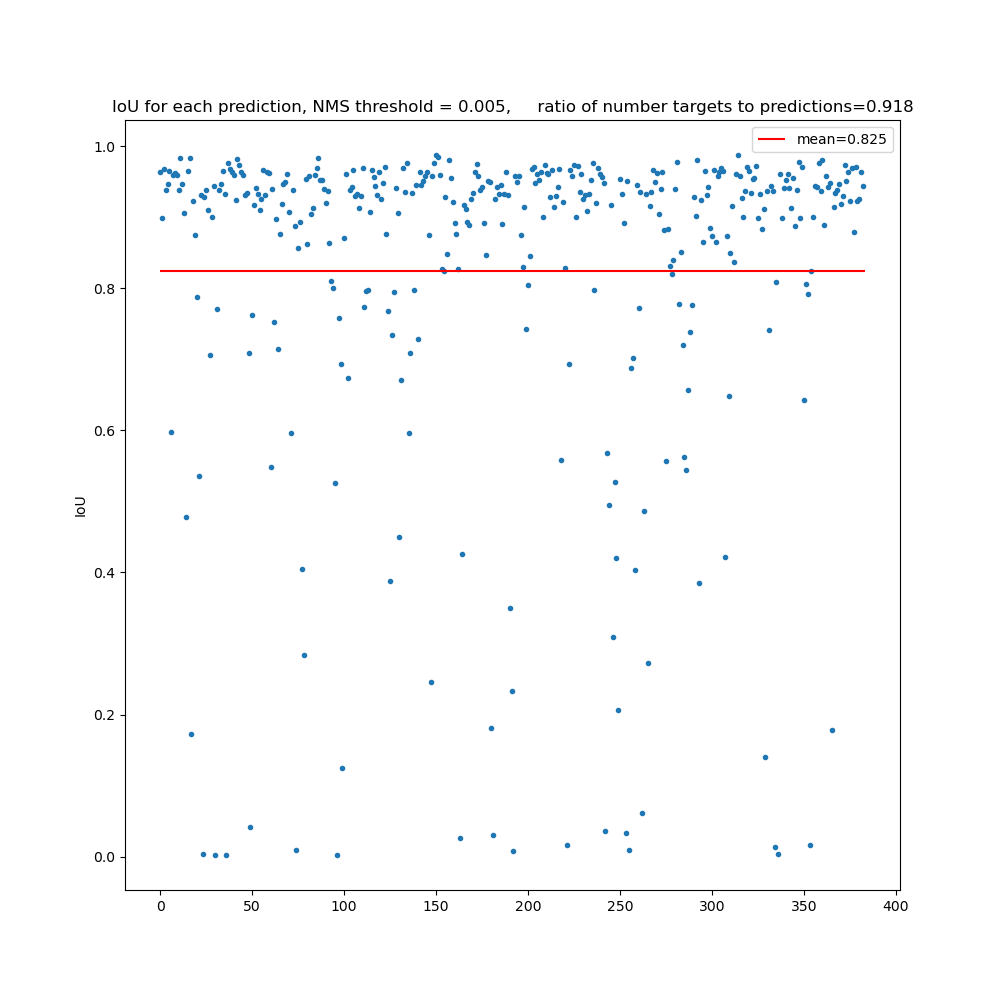

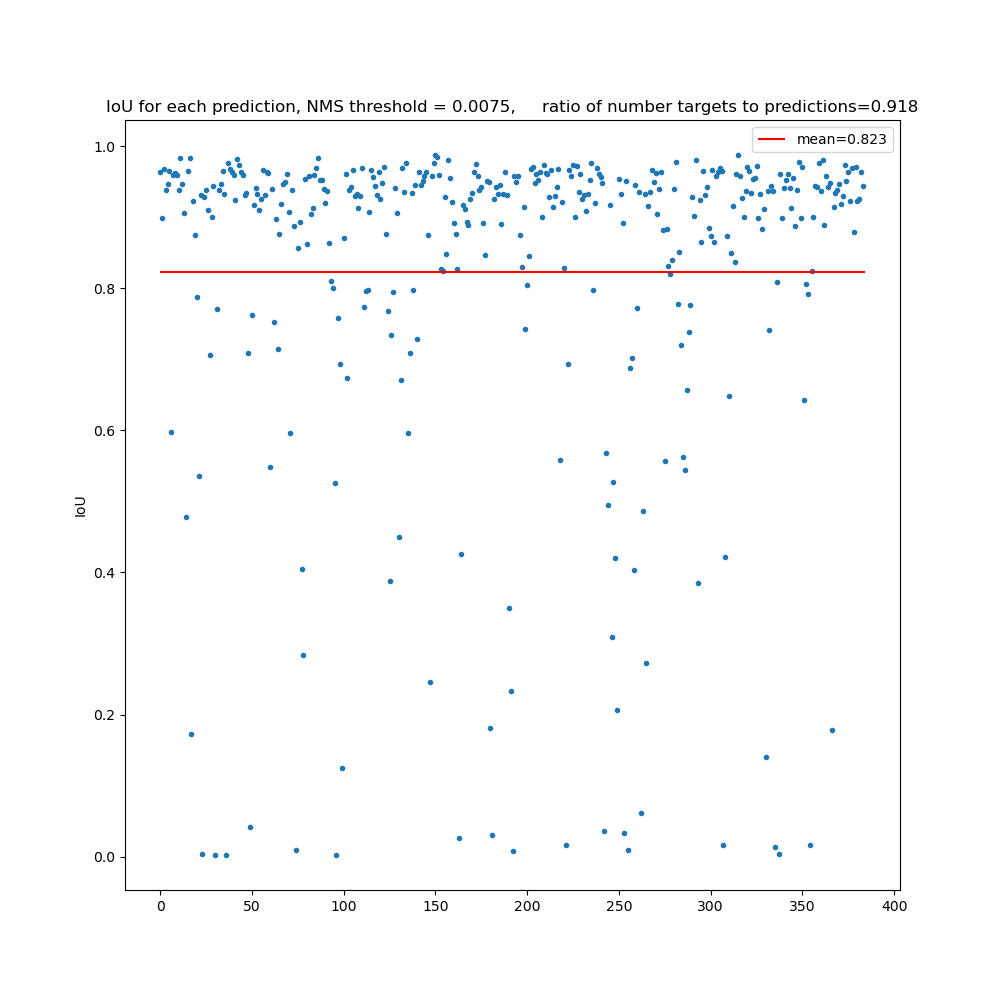

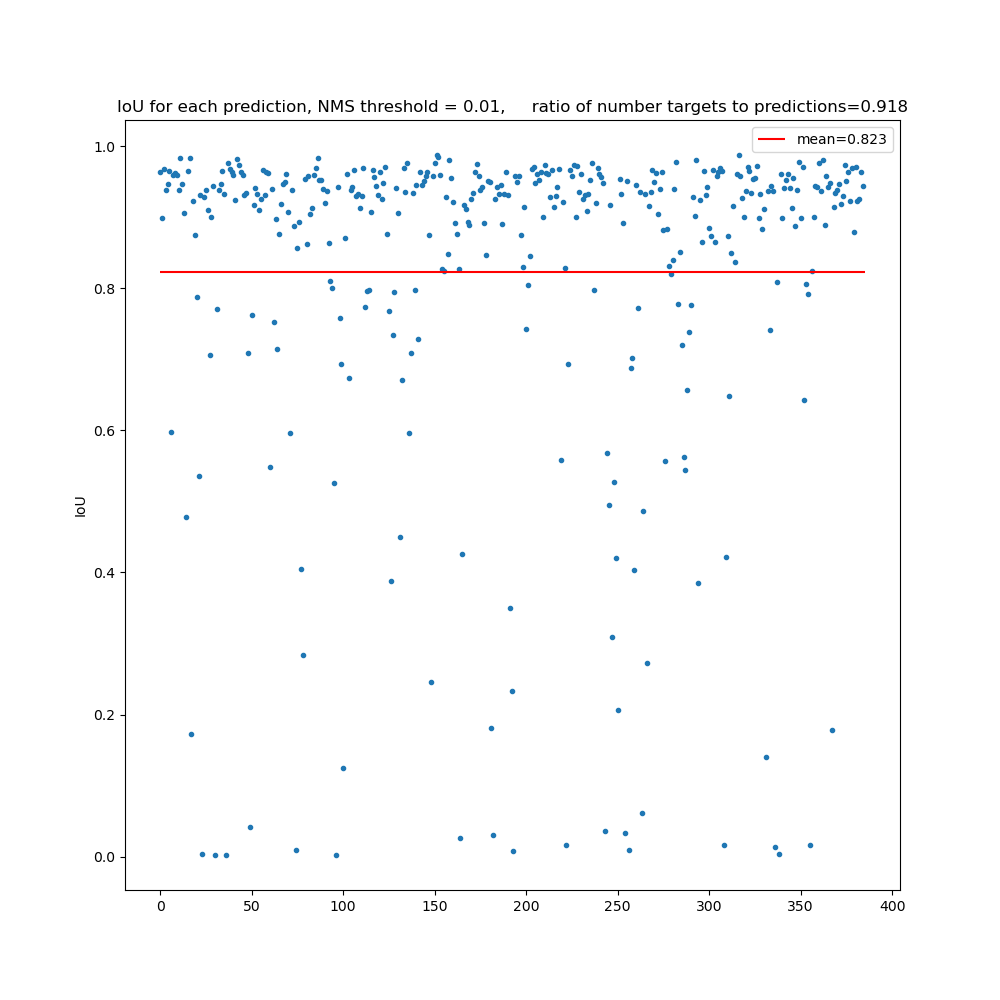

In [79]:
plot_ious(iou_info_3, iou_thresholds_3)

#### Hit the limit of improvement with reducing IoU threshold for the NMS somewhere between .05 and .1. Now realizing that it would have been informative to get the ratio of targets to predictions in each case rather than the binary num_boxes_target = num_boxes_predicted. Will fix this later, need a climbing break. 
- [x] **fixed**

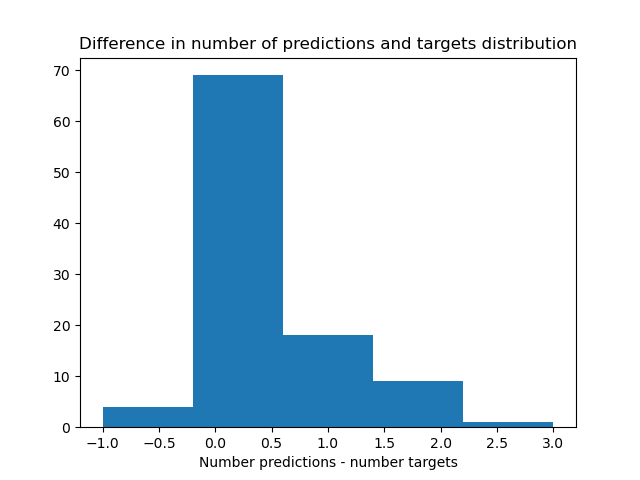

In [364]:
%matplotlib widget
num_preds = np.array(iou_info_3[0][1])
num_targs = np.array(iou_info_3[0][2])
plt.hist(num_preds - num_targs, bins=5)
plt.xlabel('Number predictions - number targets')
plt.title('Difference in number of predictions and targets distribution');

In [78]:
num_targs.sum()/num_preds.sum()

0.9176470588235294

#### Looks quite good, but hard to get a handle on things without having matched the predictions to the target it is supposed to match.

## Calculate Mean Average Precision by hand because the built-in method keeps failing.
##### Steps to accomplish:
- [x] Need to associate the prediction with a ground-truth target
    - [x] Calculate the distance of the two corners from the corners of all the targets in the image
    - [x] Average this value
    - [x] The associated target will be the one with the minimum corner distance
    - [x] If multiple predictions assoiciated with a single target later steps will classify them as false positives
- [x] Calculate IoU of the prediction and the target
- [x] Apply IoU threshold, this is a value that can be tuned, best to produce several curves with varying values
    - [x] Predictions that pass the IoU threshold count as True Positive
        - [x] If multiple pass then the others with lower IoU count as False Positive
    - [x] Predictions that fail the IoU threshold cut count as False Positive
    - [x] If a target has no overlap with any box it is counted as a False Negative
- [x] With these calculate Precision and Recall
- Interpolate by taking max of future values in PR curve
    - Why? In theory the wiggliness is due to fluctuations in the test set, so with a larger set it should be monotonic, and so assume it is so
- Calculate the arithmetic mean of the points in the PR curve
**later found these latter steps to be irrelevant unfortunately**

In [365]:
def euclid(p1, p2):
    '''
    Euclidean distance between two points, input is torch.tensor
    '''
    return (p1-p2).square().sum().sqrt()

def box_dist(box1, box2):
    '''
    Mean distance of the corners of the two boundary boxes, 
    i.e. mean(dist(lower_corner1, lower_corner2), dist(upper_corner1, upper_corner2))
    '''
    return (euclid(box1[:2], box2[:2]) + euclid(box1[2:], box2[2:]))/2.

def min_box_dist(preds, targets):
    '''
    Given list of prediction boundary boxes for an image and list of ground-truth targets 
    returns the target indices that are closest to the predicted box
    '''
    # Define return list
    inds = []
    # Define index to be stored in list
    ind = 0
    # Loop over predictions
    for i, pred in enumerate(preds):
        # Define arbitrarily large min_dist to start
        min_dist = 1e9
        # If made it through loop then need to append the index
        if i != 0:
            inds.append(ind)
        # Loop over targets
        for j, target in enumerate(targets):
            # Calculate distance
            dist = box_dist(pred, target)
            # If new min found then update min and index
            if dist < min_dist:
                min_dist = dist
                ind = j
    # Make sure to append index from last iteration
    inds.append(ind)
    
    return inds

def iou(preds, targets):
    '''
    Given prediction boundary boxes and associated targets calculate the iou for each prediction
    '''
    return box_iou(preds, targets).diag()

def iou_threshold(ious, threshold=.5):
    '''
    Return array of bools indicating whether each input IoU passed the threshold
    '''
    return ious>threshold

def get_pos_neg(preds, targets, threshold=.5):
    '''
    Measure the True Positive, False Positive, and False Negative values for the prediction and target boxes with a given IoU threshold.
    Returns TP, FP, FN
    '''
    # Get the IoU info from the preds and targets
    targ_inds = min_box_dist(preds, targets)
    ious = iou(preds, targets[targ_inds])
    iou_thresh = iou_threshold(ious, threshold)
    
    # define return variables
    tp = 0
    fp = 0
    fn = 0
    
    # define list to store indices as we go to check for duplicates
    temp_list = []
    # loop over the predictions
    for i in range(len(preds)):
        # if iou is 0 then it is a false negative, and don't need to worry 
        # about the target being possibly repeated
        if ious[i] == 0:
            fn +=1
        # check if the target has already been associated with prediction
        # if so, increment false positive. Don't need to append index to temp_list
        elif targ_inds[i] in temp_list:
            fp += 1
        # now check if made it past threshold, negating to cover the fp case.
        # need to update temp_list in this case
        elif not iou_thresh[i]:
            fp +=1
            temp_list.append(targ_inds[i])
        # if we made it to here it is a true positive
        else:
            tp += 1
            temp_list.append(targ_inds[i])

    return tp, fp, fn

def prec(tp, fp):
    '''
    Calculate precision
    '''
    return tp/(tp+fp)

def rec(tp, fn, targs):
    '''
    Calculate recall
    '''
    return tp/(tp+fn)

def precision_recall(dm, score_thresholds, iou_threshold=.5):
    '''
    For a given range of score thresholds and a datamodule object, calculate
    the precision and recall of the Faster RCNN model. Save as csv for later plotting
    '''
    recall_ = []
    precision_ = []
    tp = 0
    fp = 0
    fn = 0
    j=0
    for score_thresh in score_thresholds:
        dataiter = iter(dm.test_dataloader())
        iterating = True
        i=0
        while iterating:
            try:
                if not i%25:
                    print(f'On image {i}, score_threshold {score_thresh}')
                imgs, targets = next(dataiter)
                preds = cres_lm(imgs)
                preds = apply_score_cut(preds, score_thresh)
                cm = get_pos_neg(preds[0]['boxes'], targets[0]['boxes'], iou_threshold)
                tp += cm[0]
                fp += cm[1]
                fn += cm[2]
                i += 1
            except:
                iterating = False
                j += 1
                recall_.append(rec(tp, fp, targets[0]['boxes']))
                precision_.append(prec(tp, fn))

    pr_curve = pd.DataFrame({'precision': precision_, 'recall':recall_})
    pr_curve.to_csv(f'pr_curves/pr_curve_iou-threshold={iou_threshold}.csv')

    return precision_, recall_

In [283]:
test_dataiter = iter(cres_dm.test_dataloader())

In [322]:
score_thresholds = np.linspace(0, .6, 1)

In [316]:
precision, recall = precision_recall(cres_dm, score_thresholds, iou_threshold=.5)

On image 0, score_threshold 0.0
On image 25, score_threshold 0.0
On image 50, score_threshold 0.0
On image 75, score_threshold 0.0
On image 100, score_threshold 0.0
On image 0, score_threshold 0.031578947368421054
On image 25, score_threshold 0.031578947368421054
On image 50, score_threshold 0.031578947368421054
On image 75, score_threshold 0.031578947368421054
On image 100, score_threshold 0.031578947368421054
On image 0, score_threshold 0.06315789473684211
On image 25, score_threshold 0.06315789473684211
On image 50, score_threshold 0.06315789473684211
On image 75, score_threshold 0.06315789473684211
On image 100, score_threshold 0.06315789473684211
On image 0, score_threshold 0.09473684210526316
On image 25, score_threshold 0.09473684210526316
On image 50, score_threshold 0.09473684210526316
On image 75, score_threshold 0.09473684210526316
On image 100, score_threshold 0.09473684210526316
On image 0, score_threshold 0.12631578947368421
On image 25, score_threshold 0.1263157894736842

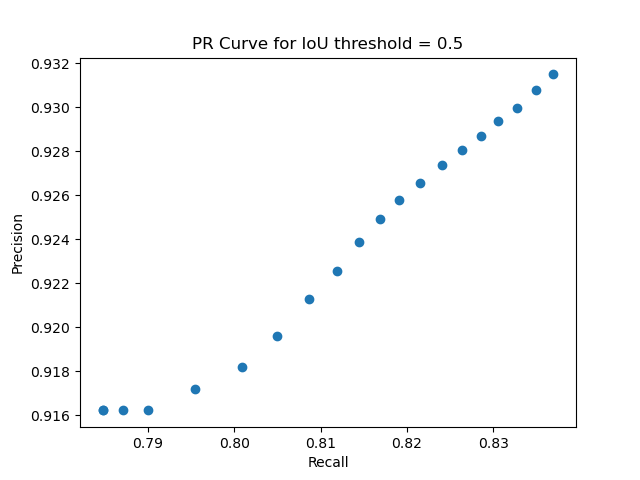

In [318]:
%matplotlib widget
pr = pd.read_csv('pr_curves/pr_curve_denomtest_iou-threshold=0.5.csv')
plt.scatter(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for IoU threshold = 0.5');

#### Precision vs. Recall curve did not come out as expected, all the reading I have done has indicated it should be monotonically decreasing. This is probably due to some miscalculation I did in the process, but I need to move on. At least I can associate predictions with targets now, so I can get a better handle on the mean IoU.

## Revisiting IoU calculation but with `min_box_dist` functionality included.
#### Ignoring NMS this time around because I worry about dropping boxes that are overlapped simply because events are overlapped.

In [398]:
def get_ious_matched(score_cut):
    '''
    Function for getting all the IoU value for a predicted bbox in a given image for given score_cut
    '''
    iou_list = []
    pred_len = []
    targ_len = []
    test_dataiter = iter(cres_dm.test_dataloader())
    iterating = True
    i=0
    while iterating:
        try:
            # Update user that function is running
            if not i%25:
                print(f'On image {i}')
            # get image and target from test dataloader
            imgs, targets = test_dataiter.next()

            # generate prediction from model
            preds = cres_lm(imgs)
            # only take preds with score > .5
            preds = apply_score_cut(preds, score_cut)

            # Match preds to targets
            targ_inds = min_box_dist(preds[0]['boxes'], targets[0]['boxes'])

            # Store the IoU for each prediction
            iou_list += iou(preds[0]['boxes'], targets[0]['boxes'][targ_inds]).tolist()

            # Also store if the number of predictions for the image match the number of targets
            pred_len.append(len(preds[0]['boxes']))
            targ_len.append(len(targets[0]['boxes']))

            # Increment sanity counter since this takes a while to run
            i+=1

        # eventually the iteration fails, so capture that here 
        except:
            # Just to guarantee that we exit the loop...
            iterating = False
            # Return IoU values and info on number of preds/targets
            return iou_list, pred_len, targ_len
        
        
def plot_ious(ious, score_cuts):
    '''
    Function for plotting the output of the IoU function above
    '''
    for i, score in enumerate(score_cuts):
        iou_temp = torch.detach(torch.tensor(ious[i][0])).numpy()
        plt.figure(figsize=(10,10))
        plt.scatter(list(range(len(iou_temp))), iou_temp, marker='.')
        plt.hlines(y=iou_temp.mean(),xmin=0, xmax=len(iou_temp), color='red', label=f'mean={iou_temp.mean().round(3):.3f}')
        plt.ylabel('IoU')
        plt.xlabel('Prediction number')
        plt.title(f'IoU for each prediction, score threshold = {score}, ratio of number targets to predictions={sum(ious[i][2])/sum(ious[i][1]) :.3f}')
        plt.legend()
        plt.show()
    return None

#### Final check: let's look at this at different score cut values

In [385]:
score_cuts = [.5, .6, .7, .8]
iou_info_score = [get_ious_matched(score) for score in score_cuts]

On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100
On image 0
On image 25
On image 50
On image 75
On image 100


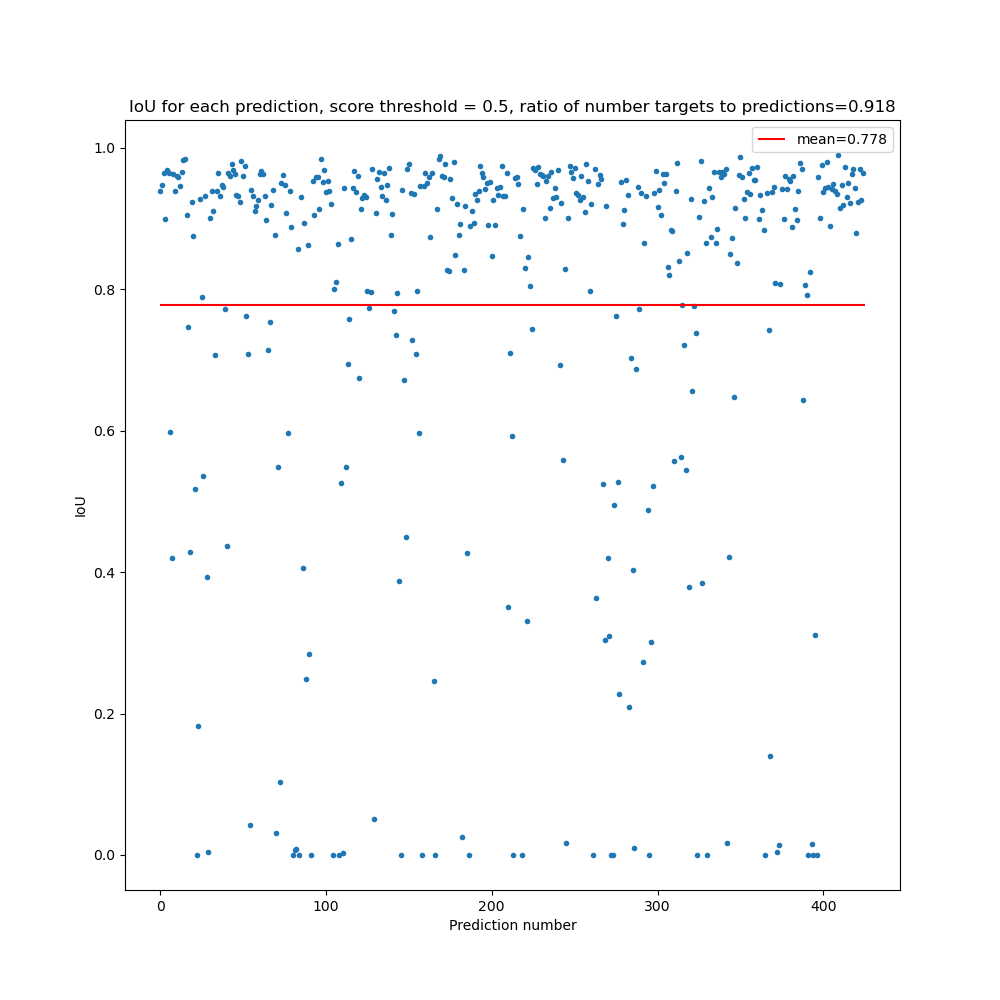

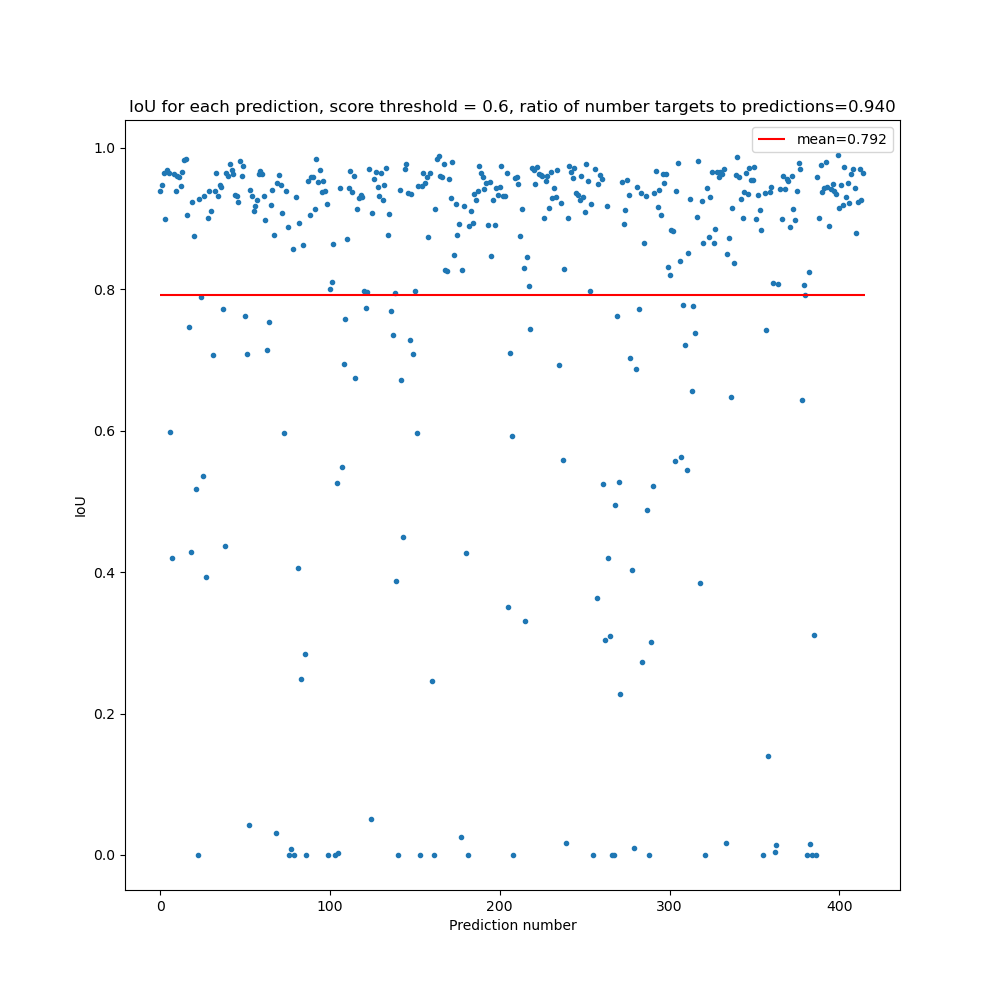

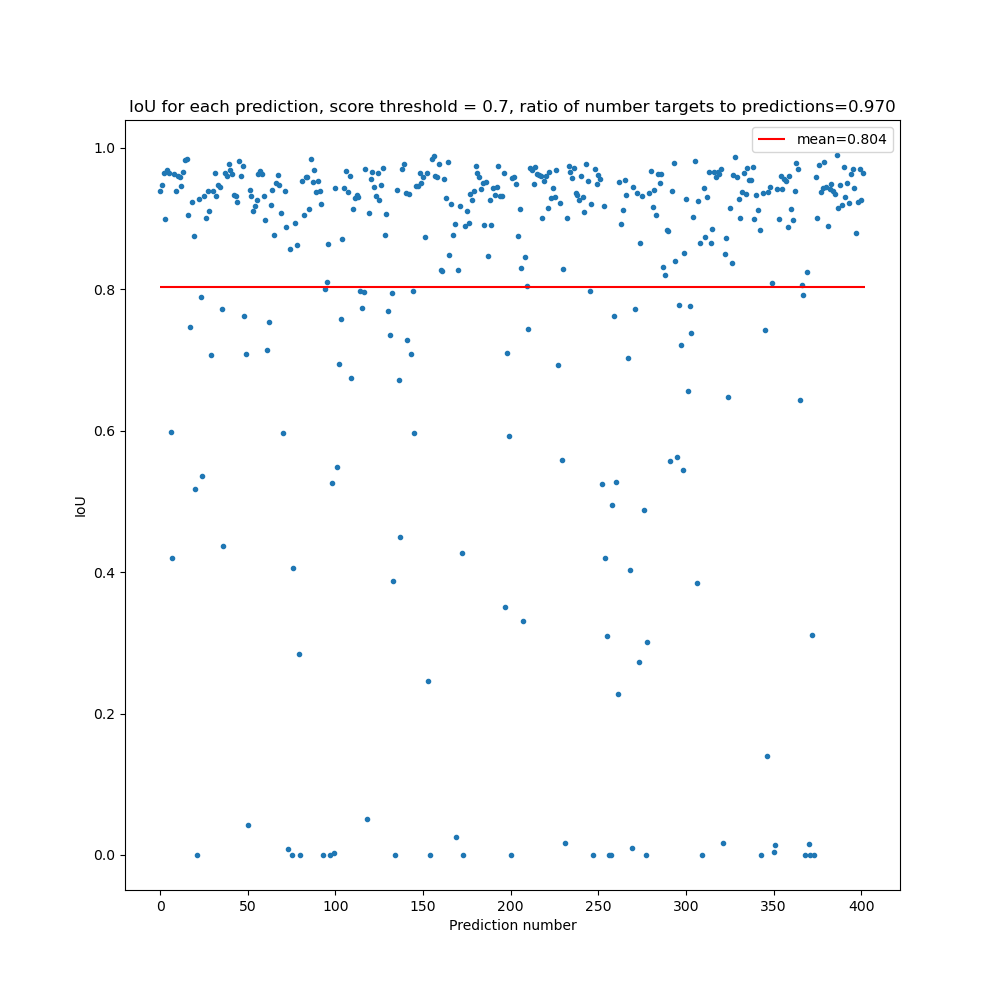

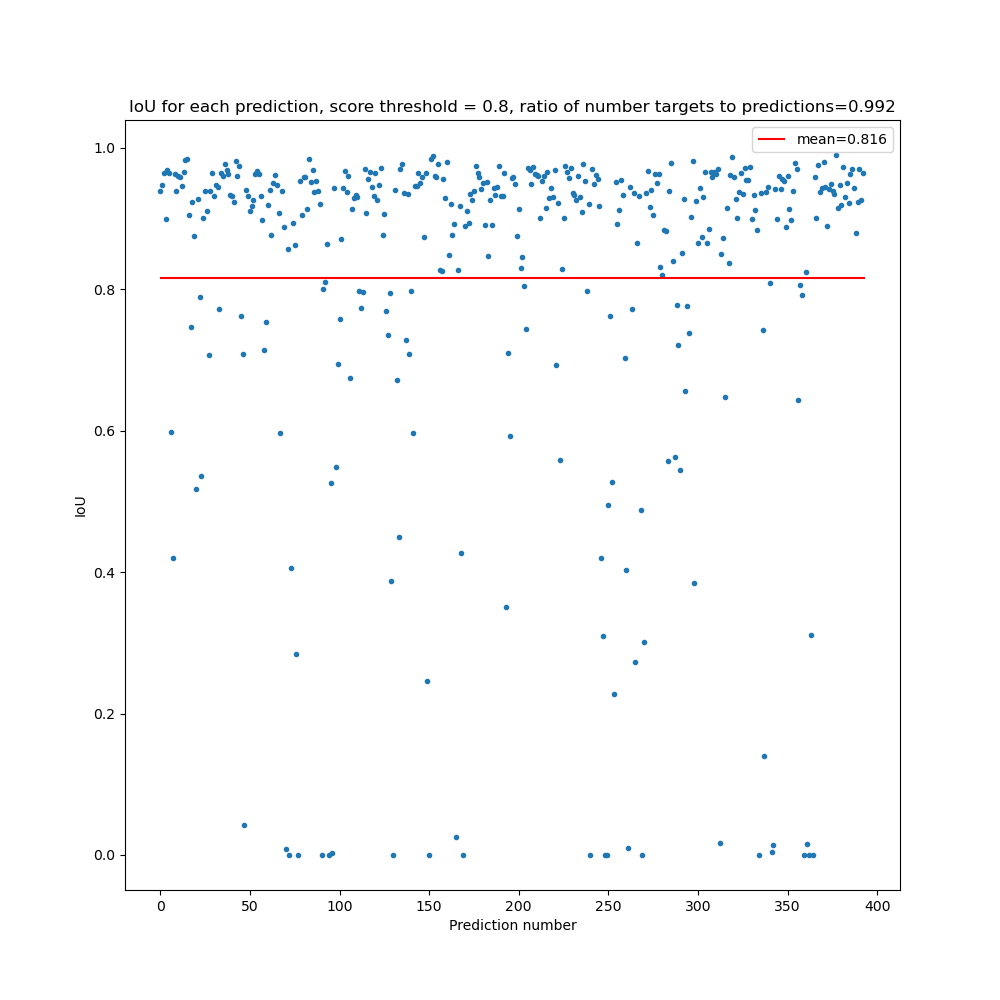

In [399]:
%matplotlib widget
plot_ious(iou_info_score, score_cuts)

#### Looks good! This is where I will be finishing for now. There is more to be done, such is the nature of science. However, I feel like I am leaving this in a good place for a future Ph.D. student to take over for systematic study of the analysis.